# Time Series window data 생성 및 모델별 성능 비교

1. Persistence algorithm 을 이용한 forecasting 
2. simple 1 layer NN 을 이용한 forecasting  
3. Deep NN을  이용한 forecasting  
4. LSTM 을  이용한 forecasting

## Sunspots 데이터셋을 활용하여 window_dataset 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0) # 첫 줄은 header이므로 skip 
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [2]:
df.tail()

,Date,Monthly Mean Total Sunspot Number
3230,2018-03-31,2.5
3231,2018-04-30,8.9
3232,2018-05-31,13.2
3233,2018-06-30,15.9
3234,2018-07-31,1.6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3235 entries, 0 to 3234
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3235 non-null   object 
 1   Monthly Mean Total Sunspot Number  3235 non-null   float64
dtypes: float64(1), object(1)
memory usage: 75.8+ KB


- 시간 절약을 위해 최근 500 개월치 data 만 이용

time 변수는 DataFrame의 마지막 500개 행의 첫 번째 열(0번 인덱스)에 해당하는 값을 포함하고 있습니다. time_series 변수는 마지막 500개 행의 두 번째 열(1번 인덱스)에 해당하는 값을 포함하고 있습니다.

In [4]:
time = df.iloc[-500:, 0].values
time_series = df.iloc[-500:, 1].values
time.shape, time_series.shape

((500,), (500,))

## Supervised Learning dataset 작성

- Persistent Algorithm 과 비교하기 위해 Many-to-One style 로 예측 

windowed_dataset 함수는 다음 단계를 수행합니다:

1. series를 입력으로 받아 tf.data.Dataset.from_tensor_slices() 함수를 사용하여 TensorFlow Dataset 객체를 생성합니다.  
2. ds.window() 함수를 사용하여 데이터를 겹치는 윈도우로 분할합니다. 윈도우 크기는 window_size+1로 설정하며, 각 윈도우는 1씩 이동(shift)합니다. drop_remainder=True를 설정하여 길이가 부족한 마지막 윈도우를 제거합니다.  
3. ds.flat_map() 함수를 사용하여 각 윈도우를 일련의 데이터 포인트로 평평하게(flatten) 만듭니다.  
4. ds.shuffle() 함수를 사용하여 데이터를 섞습니다. shuffle_buffer 매개 변수는 셔플링에 사용되는 버퍼 크기를 결정합니다.  
5. ds.map() 함수를 사용하여 각 윈도우의 마지막 데이터 포인트를 레이블로 설정하고 나머지를 입력 특성으로 사용합니다. 즉, 각 윈도우에서 하나의 출력 값(single step output)이 생성됩니다.  
6. ds.batch() 함수를 사용하여 데이터를 batch_size 크기의 배치로 구성하고, ds.prefetch(1)을 사용하여 학습 중에 다음 배치를 미리 가져옵니다.  

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))   # single step output
    ds = ds.batch(batch_size).prefetch(1)
    return ds

### train/validation set 분리

In [6]:
split_time = 450

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(450, 50, 450, 50)

In [7]:
window_size = 30
batch_size = 64
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [8]:
for x, y in train_ds:
    print('x = ', x.numpy().shape)
    print('y = ', y.numpy().shape)
    break

x =  (64, 30)
y =  (64,)


## 1. Persistence algorithm 을 이용한 forecasting 

- Persistence Algorithm : last value 를 next value 로 예측에 사용  

naive_forecast는 주어진 시계열 데이터의 단순한 예측값을 생성합니다. 여기서는 테스트 데이터셋의 이전 값(즉, 마지막 훈련 데이터셋의 값)을 사용하여 테스트 데이터셋을 예측합니다. 이 예측 방법은 매우 단순하며 실제로는 복잡한 패턴을 예측할 수 없지만, 복잡한 모델과의 성능 비교를 위한 기준점으로 사용할 수 있습니다.

naive_forecast에 저장된 처음 10개의 예측값은 다음과 같습니다:

In [9]:
naive_forecast = time_series[split_time-1:-1]
naive_forecast[:10]

array([112.5, 102.9, 100.2, 106.9, 130. ,  90. , 103.6, 112.9,  93. ,
        66.7])

In [10]:
X_test[:10]

array([102.9, 100.2, 106.9, 130. ,  90. , 103.6, 112.9,  93. ,  66.7,
        54.5])

테스트 데이터셋과 naive_forecast 사이의 평균 제곱 오차(Mean Squared Error, MSE)와 평균 절대 오차(Mean Absolute Error, MAE)를 계산합니다.  
일반적으로 낮은 값이 더 좋은 예측 성능을 나타냅니다.

In [11]:
print(mean_squared_error(X_test, naive_forecast))
print(mean_absolute_error(X_test, naive_forecast))

194.96940000000004
10.737999999999998


In [12]:
compare_models = {}

compare_models['persistence'] = \
     [mean_squared_error(X_test, naive_forecast), mean_absolute_error(X_test, naive_forecast)]

compare_models

{'persistence': [194.96940000000004, 10.737999999999998]}

## 2. simple 1 layer NN 을 이용한 forecasting - Linear Regression

input_shape: 입력 데이터의 형태를 지정합니다. 여기서 입력 데이터의 형태는 [window_size]입니다.
이 모델은 각 시계열 윈도우에 대해 하나의 출력 값을 예측합니다. 이 간단한 모델은 선형 회귀와 유사하게 작동하며, 시계열 데이터의 간단한 패턴을 포착할 수 있습니다. 

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=[window_size])
])

model.compile(loss='mse', optimizer='adam')
model.fit(train_ds, epochs=100, verbose=1)

Epoch 1/100
7/7 [==============================] - 0s 5ms/step - loss: 46673.0938
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 36949.1367
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 28939.4688
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 22030.2930
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 16369.2754
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 12142.5488
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 8870.7109
Epoch 8/100
7/7 [==============================] - 0s 913us/step - loss: 6540.3511
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 4944.7295
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 3893.3062
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 3165.0461
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 2764.8083
Epoch 13/100
7/7 

시계열 데이터를 다룰 때, 우리는 전체 데이터를 훈련 데이터와 테스트 데이터로 나눕니다. 이 과정에서 'window_size'라는 개념을 사용하는데, 이는 한 번에 고려할 데이터의 범위(길이)를 의미합니다. 'split_time'은 훈련 데이터와 테스트 데이터를 나누는 지점을 나타냅니다.

예를 들어, 'split_time'이 450이고 'window_size'가 30일 때, 'split_time - window_size' 계산은 420이 됩니다. 이는 훈련 데이터에서 마지막으로 고려할 데이터 범위가 시계열 데이터의 420번째 위치에서 시작한다는 의미입니다. 즉, 이 위치부터 'window_size'만큼의 데이터를 마지막 훈련 데이터로 사용합니다.

시계열 데이터의 전체 길이는 'len(time_series)'로 확인할 수 있습니다. 이 정보를 바탕으로, 테스트 데이터를 예측할 때는 'X_test'의 길이만큼 예측을 진행합니다. 그리고 예측 결과의 마지막 부분을 'time_series[-len(X_test):]'를 사용하여 추출합니다. 이렇게 하면 예측 결과와 'X_test'의 길이가 같아져서, 실제 값과 예측 값을 비교하기 쉬워집니다.

간단히 말해서, 우리는 시계열 데이터의 끝부분에서 'window_size'만큼 떨어진 위치를 시작점으로 삼아 테스트 데이터를 예측하고, 이 예측 결과 중 마지막 부분을 사용하여 실제 테스트 데이터와 비교합니다.

이 코드는 시계열 데이터에서 테스트 데이터에 해당하는 부분의 예측값을 계산합니다. 예측 과정은 `split_time` 지점부터 시계열 데이터의 끝까지 진행되며, 각 예측에는 바로 앞의 `window_size` 만큼의 데이터가 사용됩니다.

예를 들어, 만약 `split_time`이 450이고 시계열 데이터의 총 길이(`len(time_series)`)가 500이라면, 이 코드는 450번째 시점부터 499번째 시점까지, 즉 테스트 데이터에 해당하는 각 시점에 대해 예측을 수행합니다. 결과적으로 `forecast` 리스트에는 총 50개의 예측값이 저장되며, 이는 테스트 데이터의 길이인 500에서 450을 뺀 값과 일치합니다.

In [14]:
split_time-window_size, len(time_series)

(420, 500)

In [15]:
forecast = []  # 예측값을 저장할 리스트를 초기화

# split_time부터 시계열 데이터의 끝까지 반복
for time in range(split_time, len(time_series)):
    # 현재 시점에서 window_size만큼 이전 데이터를 사용하여 예측을 수행합니다.
    prediction = model.predict(time_series[time-window_size:time].reshape(1, -1), verbose=0)
    # 예측 결과를 forecast 리스트에 추가합니다. prediction[0][0]는 예측된 값을 가져옵니다.
    forecast.append(prediction[0][0])

print(forecast)

[149.88876, 67.00424, 118.83344, 97.70947, 70.131004, 124.76142, 97.52811, 116.825035, 124.89692, 149.26173, 71.85272, 80.989265, 68.359184, 90.40519, 45.021603, 73.925835, 120.70872, 59.571167, 94.42229, 56.37274, 29.277328, 34.47326, 56.408752, 36.37441, 24.378155, 53.66551, 44.389168, 29.694263, 35.91768, 27.681252, 13.563148, 24.70996, 32.984188, 29.231672, 13.820778, 3.726029, 53.062447, 29.754395, 5.104979, 10.797017, 6.4261646, 27.60383, 31.033855, 0.9871618, 20.870317, 3.9421947, -12.021515, 8.794672, -4.876899, 32.17691]


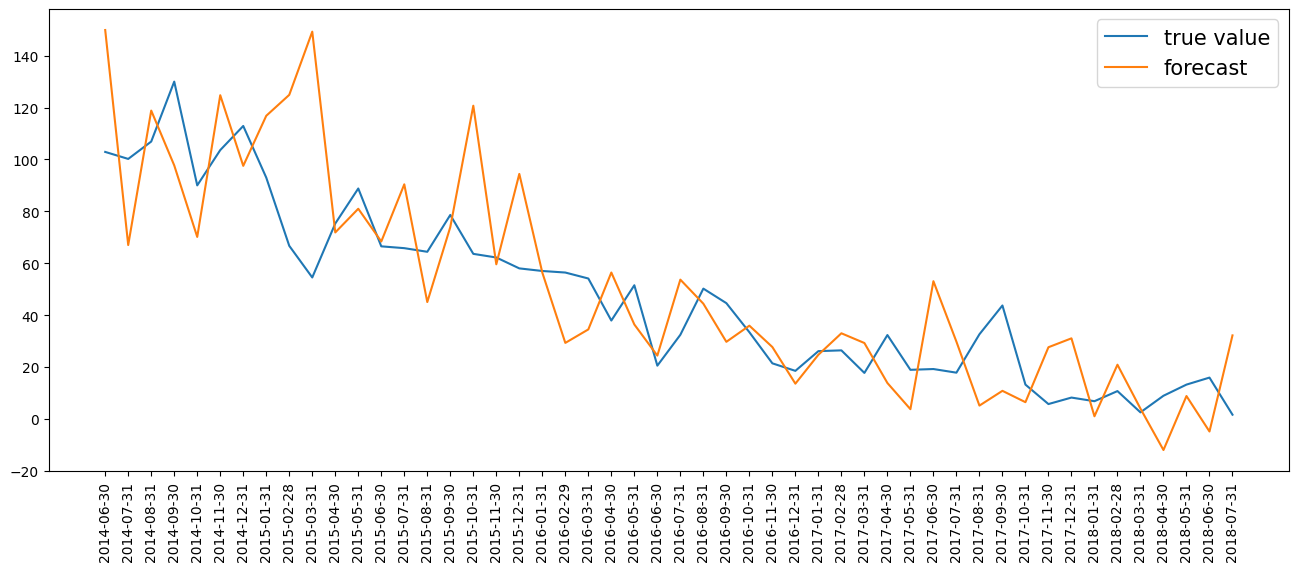

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='true value')
plt.plot(time_test, forecast, label='forecast')
plt.xticks(rotation=90)
plt.legend(fontsize=15)
plt.show()

In [17]:
print(tf.keras.metrics.mean_squared_error(X_test, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy())

671.1283
19.222555


In [18]:
compare_models['1 Layer Dense'] = \
     [tf.keras.metrics.mean_squared_error(X_test, forecast).numpy(), 
      tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy()]
compare_models

{'persistence': [194.96940000000004, 10.737999999999998],
 '1 Layer Dense': [671.1283, 19.222555]}

## 3. Deep NN을  이용한 forecasting

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer='adam')

history = model.fit(train_ds,epochs=100,verbose=1)

Epoch 1/100
7/7 [==============================] - 0s 6ms/step - loss: 15836.9277
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 2794.3435
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 2178.3596
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1785.5908
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 1180.1357
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 1076.7098
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 843.7115
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 802.0745
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 761.4152
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 719.5775
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 718.3360
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 696.8853
Epoch 13/100
7/7 [============

In [20]:
forecast = []

for time in range(split_time, len(time_series)):
    prediction = model.predict(time_series[time-window_size:time].reshape(1, -1), verbose=0)
    forecast.append(prediction[0][0])

print(forecast)

[119.66438, 113.5242, 102.49783, 112.53833, 121.28363, 93.420044, 95.70184, 98.74428, 94.52279, 81.05643, 76.56689, 82.62371, 77.196266, 73.272606, 72.1648, 58.303898, 61.939995, 72.261284, 70.26221, 60.690243, 57.26185, 51.272457, 50.07854, 43.972054, 48.287605, 35.7991, 43.0325, 50.21912, 56.197777, 38.259003, 21.732477, 19.92424, 27.51429, 26.637405, 24.866028, 33.821857, 21.27235, 25.08843, 16.806623, 21.910925, 37.344124, 13.127786, 8.210311, 16.190638, 13.544281, 15.951791, 10.121576, 14.018403, 10.929453, 15.765498]


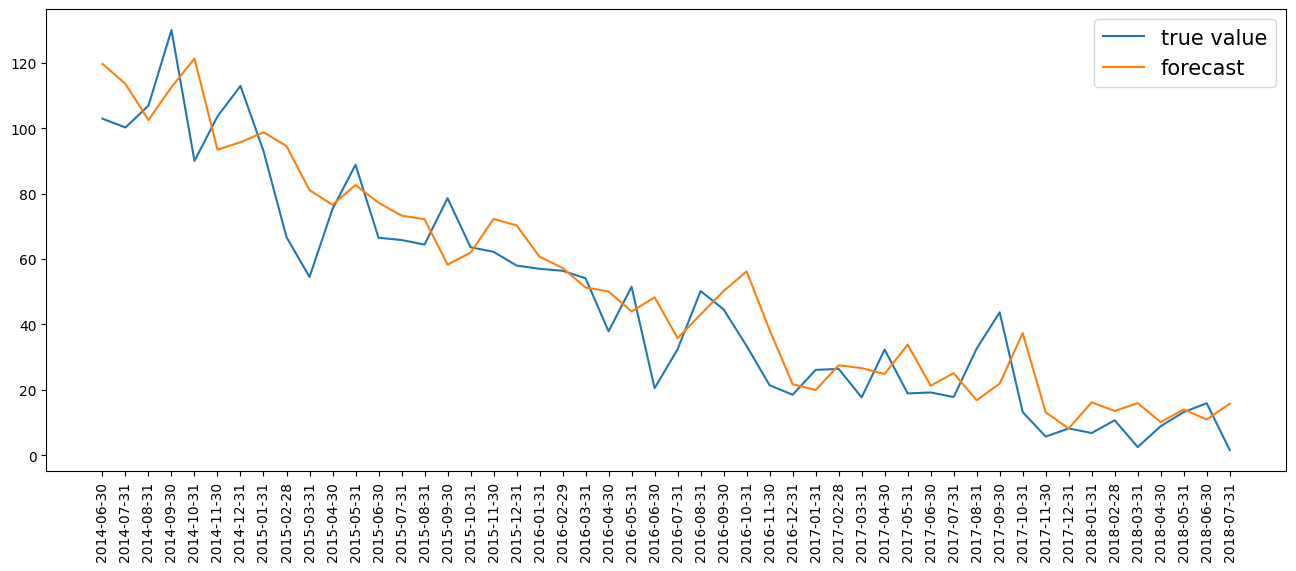

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='true value')
plt.plot(time_test, forecast, label='forecast')
plt.xticks(rotation=90)
plt.legend(fontsize=15)
plt.show()

In [22]:
print(tf.keras.metrics.mean_squared_error(X_test, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy())

176.7986
10.526285


In [23]:
compare_models['Deep NN'] = \
     [tf.keras.metrics.mean_squared_error(X_test, forecast).numpy(), 
      tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy()]
compare_models

{'persistence': [194.96940000000004, 10.737999999999998],
 '1 Layer Dense': [671.1283, 19.222555],
 'Deep NN': [176.7986, 10.526285]}

## 4. LSTM 을  이용한 forecasting

- RNN 은 3 Dimension input 이 필요하므로 Lambda layer 를 이용하여 2D $\rightarrow$ 3D expand  

### 4-1. Simple LSTM

- 첫 번째 람다 레이어는 차원을 확장하는 데 도움이 됩니다. 여기서는 배열을 1차원 확장하고 모델이 모든 길이의 시퀀스를 사용할 수 있음을 의미하는 input_shape=[None]을 설정 합니다.

- 최종 람다 계층은 출력을 100배 확장하여 훈련에 도움이 될 수 있습니다. RNN의 기본 레이어는 -1과 1 사이의 값을 출력하는 tanh입니다. 출력을 스케일링하면 이러한 값을 일반적으로 40, 50, 60 등의 값인 시계열에 더 가깝게 만들 수 있습니다.

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_ds, epochs=100, verbose=1)

Epoch 1/100
7/7 [==============================] - 1s 11ms/step - loss: 6944.3647
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 5765.5508
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 5041.2554
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 4356.9907
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 3411.3364
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 2450.2083
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 1712.7423
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 1394.8309
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 1259.9862
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 1167.0037
Epoch 11/100
7/7 [==============================] - 0s 7ms/step - loss: 1099.1660
Epoch 12/100
7/7 [==============================] - 0s 6ms/step - loss: 1034.7069
Epoch 13/100
7/7 [======

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


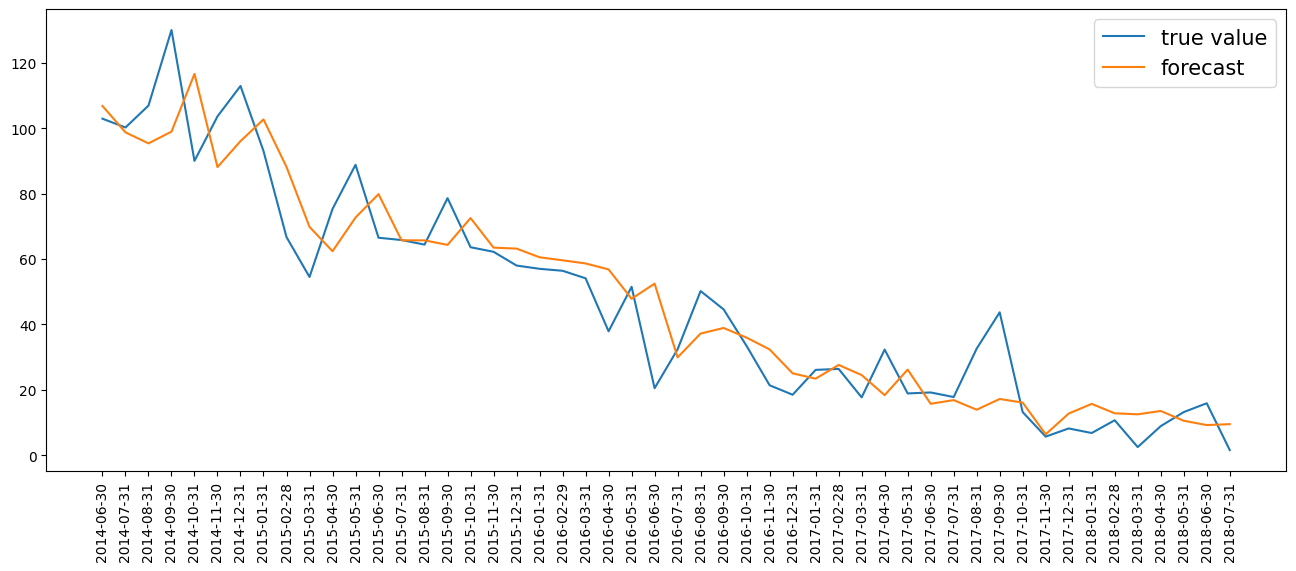

In [26]:
forecast = []

for time in range(split_time, len(time_series)):
    prediction = model.predict(time_series[time-window_size:time].reshape(1, -1), verbose=0)
    forecast.append(prediction[0][0])

plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='true value')
plt.plot(time_test, forecast, label='forecast')
plt.xticks(rotation=90)
plt.legend(fontsize=15)
plt.show()

In [27]:
print(tf.keras.metrics.mean_squared_error(X_test, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy())

151.65338
9.327949


In [28]:
compare_models['Simple LSTM'] = \
     [tf.keras.metrics.mean_squared_error(X_test, forecast).numpy(), 
      tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy()]
compare_models

{'persistence': [194.96940000000004, 10.737999999999998],
 '1 Layer Dense': [671.1283, 19.222555],
 'Deep NN': [176.7986, 10.526285],
 'Simple LSTM': [151.65338, 9.327949]}

### 4-2. Stacked + Bidirectoinal LSTM

이 코드는 양방향 LSTM 모델을 정의합니다. 여기에 포함된 각 층은 다음과 같습니다:

Lambda 층: 입력 데이터의 마지막 축을 확장하여 형태를 [None]에서 [None, 1]로 변경합니다. 이렇게 하면 입력 데이터를 2D에서 3D로 변환하여 LSTM 층에 적합한 형태로 만듭니다.

Bidirectional 층: 양방향 LSTM을 사용하여 시계열 데이터를 처리합니다. 첫 번째 양방향 LSTM 층은 32개의 유닛을 가지며, return_sequences=True로 설정되어 있어 시퀀스 전체를 출력합니다. 이렇게 하면 이 층의 출력이 다음 LSTM 층의 입력으로 사용될 수 있습니다.

또 다른 Bidirectional 층: 두 번째 양방향 LSTM 층 역시 32개의 유닛을 가지고 있지만, return_sequences의 기본값인 False로 설정되어 마지막 시간 단계의 출력만 반환합니다.

Dense 층: 출력 유닛이 1개인 완전 연결 층입니다. 이 층은 LSTM 층에서 얻은 정보를 바탕으로 시계열 데이터의 다음 값을 예측하는 역할을 합니다.

마지막 Lambda 층: 출력 값을 100배로 스케일업합니다. 이렇게 하면 네트워크가 더 큰 값의 범위를 예측할 수 있게 됩니다.

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_ds, epochs=100, verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 23ms/step - loss: 14988.2783
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - loss: 5717.3252
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 3514.4431
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 2547.5222
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 2067.8142
Epoch 6/100
7/7 [==============================] - 0s 17ms/step - loss: 1823.9543
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 1314.3551
Epoch 8/100
7/7 [==============================] - 0s 15ms/step - loss: 1061.9176
Epoch 9/100
7/7 [==============================] - 0s 15ms/step - loss: 877.1415
Epoch 10/100
7/7 [==============================] - 0s 15ms/step - loss: 761.1505
Epoch 11/100
7/7 [==============================] - 0s 15ms/step - loss: 692.7612
Epoch 12/100
7/7 [==============================] - 0s 14ms/step - loss: 693.0742
Epoch 13/100
7/7

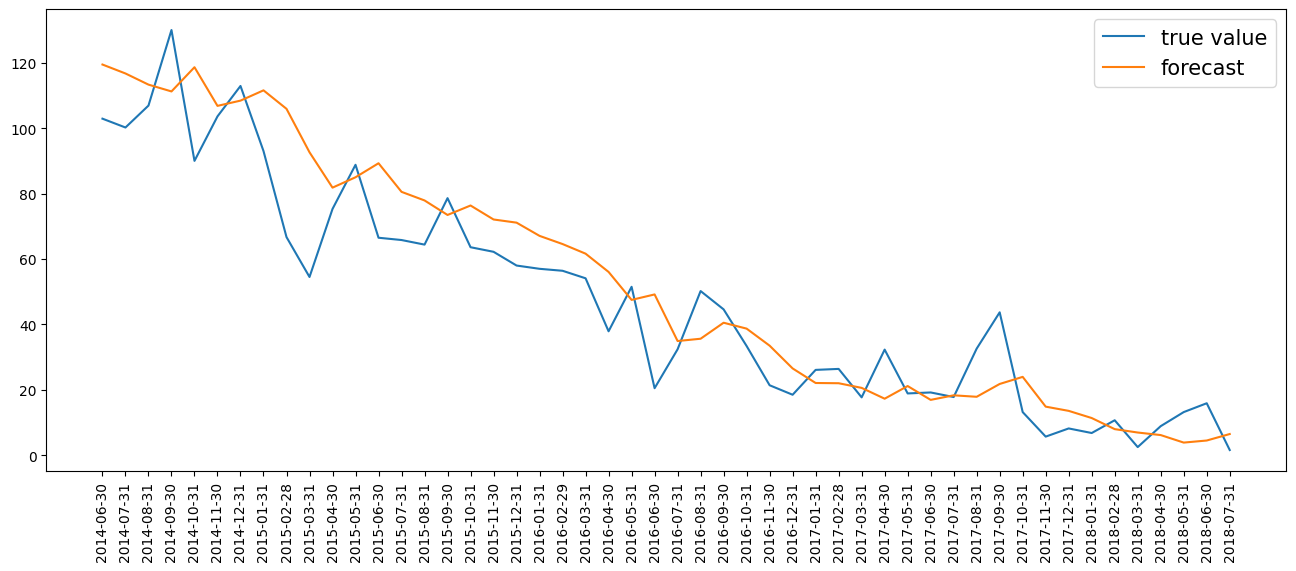

In [30]:
forecast = []

for time in range(split_time, len(time_series)):
    prediction = model.predict(time_series[time-window_size:time].reshape(1, -1), verbose=0)
    forecast.append(prediction[0][0])

plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='true value')
plt.plot(time_test, forecast, label='forecast')
plt.xticks(rotation=90)
plt.legend(fontsize=15)
plt.show()

In [31]:
print(tf.keras.metrics.mean_squared_error(X_test, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy())

198.54974
10.9855385


In [32]:
compare_models['Stacked LSTM'] = \
     [tf.keras.metrics.mean_squared_error(X_test, forecast).numpy(), 
      tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy()]
compare_models

{'persistence': [194.96940000000004, 10.737999999999998],
 '1 Layer Dense': [671.1283, 19.222555],
 'Deep NN': [176.7986, 10.526285],
 'Simple LSTM': [151.65338, 9.327949],
 'Stacked LSTM': [198.54974, 10.9855385]}